# Sentiment Analysis Using Various Approaches

## Lexicon-based approach 
- Unsupervised learning
- Based on calculating sentiment scores of words in a document from lexicons.
- Each word's sentiment is determined, and the scores are combined to calculate the overall sentiment of the sentence. 
- A lexicon is a dictionary that contains a collection of words that is categorized as positive, negative, and neutral by experts. Their scores can change over time.
- Only those words listed in the lexicon will actually be scored.
- Disadvantages: words that are not in the lexicon will not be scored; some lexicons might be better suited for a specific use; it overlooks negation (lexicons only match words and not phrases, ie "not bad" is scored more negative instead of neutral)

In [87]:
import numpy as np 
import pandas as pd
import json
import time
import re

# Text cleaning
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# NLTK Bing Liu Lexicon 
import nltk
# nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize 

# VADER 
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix

# Supervised learning 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading a subset of reviews and meta data

In [2]:
n = 1 
total_rows = 0

def process_chunks(file, chunksize = 1000):

    # Setting as global variables
    global n, total_rows  
    
    chunks = pd.read_json(file, lines=True, chunksize = chunksize)
    dfs = []  
    n_chunks = 0

    for chunk in chunks:
        dfs.append(chunk)
        n_chunks += 1  # Count the number of chunks processed
        print(len(chunk), " rows added")
        n += 1 
        total_rows += len(chunk)
        if n_chunks >= 10:  # Process only the first 5 chunks
            break  
            
    print("Done")
    print("Total rows:", total_rows)
    return pd.concat(dfs, ignore_index=True)

In [3]:
reviews = "../data/Home_and_Kitchen.jsonl"
meta = "../data/meta_Home_and_Kitchen.jsonl"

start = time.process_time()

reviews_subset = process_chunks(reviews)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the reviews dataset')
print('Execution time:', elapsed_time, 'seconds')

print('--------------')
start = time.process_time()

meta_subset = process_chunks(meta)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the meta dataset')
print('Execution time:', elapsed_time, 'seconds')

1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 10000
Created a subset of the reviews dataset
Execution time: 0.21875 seconds
--------------
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 20000
Created a subset of the meta dataset
Execution time: 1.078125 seconds


In [4]:
reviews_subset.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-26 01:03:29.298,1,True
1,5,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-12-26 08:30:10.846,0,True
2,2,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-05-25 02:54:56.788,0,True


In [5]:
reviews_subset.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

## Text Cleaning - spaCy

In [6]:
import spacy 
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Original stopwords count:', len(stop_words))

Original stopwords count: 326


In [7]:
# Updating my stopwords list 
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Include/ exclude certain words
include_stopwords = {'would', 'I'}
exclude_stopwords = {'i', 'well', 'off', 'very', 'not', 'few', 'much'}

stop_words |= include_stopwords
stop_words -= exclude_stopwords

# Remove adjectives from my stopwords using spaCy
exclude_adjectives = {word for word in stop_words if nlp(word)[0].pos_ == "ADJ"}
print(exclude_adjectives)

stop_words -= exclude_adjectives
print('Stopwords count:', len(stop_words))

{'third', 'empty', 'latter', 'whereafter', 'last', 'top', 'many', 'whole', 'due', 'serious', 'such', 'various', 'least', 'full', 'other', 'several', 'former', 'own', 'same'}
Stopwords count: 301


In [8]:
def clean_data(doc):
    doc = doc.lower()
    doc = nlp(doc)
    # Lemmatize words 
    lemmas = [token.lemma_ for token in doc]
    # Removing non-alphabetic characters and stopwords
    tokens = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stop_words]
    cleaned_doc = " ".join(tokens)
    
    return cleaned_doc

In [9]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

# Update stopwords
include_stopwords = {'would', 'I', 'not'}
exclude_stopwords = {'i'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    tokens = text.split()  # Create tokens 
    clean_tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]  # Lemmatize and remove stop words
    clean_text = " ".join(clean_tokens)  # Join clean tokens
    clean_text = " ".join(clean_text.split())  # Remove extra spaces, tabs, and new lines
    
    return clean_text

In [10]:
cleaned_text = reviews_subset.copy()
cleaned_text['spacy_text'] = cleaned_text['text'].apply(clean_data)
cleaned_text['nltk_text'] = cleaned_text['text'].apply(preprocess_text)

In [11]:
cleaned_text.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,spacy_text,nltk_text
0,1,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-26 01:03:29.298,1,True,livid receive obviously use item food scratch ...,livid received obviously used item food scratc...
1,5,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-12-26 08:30:10.846,0,True,purchase multiple reason main reason bc apt fl...,i purchased multiple reason main reason i movi...
2,2,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-05-25 02:54:56.788,0,True,videoid want love bc previously buy matching t...,videoidcebcabfbcecc i wanted love bc i previou...


## Feature Engineering 

Create new features: word count, average word length, exclamation mark count.

In [12]:
# Word count
def word_count(text):
    words = text.split()
    return len(words)

In [13]:
# Average word length 
def avg_word_length(text):
    words = text.split()
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    
    return(avg_word_length)    

In [14]:
# Exclamation mark count 
def exclamation_count(text):
    doc = nlp(text)
    exclamations = []
    for token in doc: 
        if token.text == '!':
            exclamations.append(token.text)
    return len(exclamations)

## Bing Liu Lexicon

The Bing Liu lexicon has a total of 6, 786 words with 2,005 classified as positive and 4,781 as negative. CLassification is binary (positive or negative).

In [15]:
print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words:', opinion_lexicon.positive()[:10])
print('Examples of negative words:', opinion_lexicon.negative()[:10])

Total number of words in opinion lexicon 6789
Examples of positive words: ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples of negative words: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [16]:
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
    word_dict[word] = pos_score 

# Adding the negative words to the dictionary 
for word in opinion_lexicon.negative():
    word_dict[word] = neg_score 

def bing_liu_score(text):
    sentiment_score = 0 
    bag_of_words = word_tokenize(text.lower())

    # Check if bag_of_words is empty
    if bag_of_words: 
        for word in bag_of_words: 
            if word in word_dict: 
                sentiment_score += word_dict[word]
        return sentiment_score / len(bag_of_words)
    else: 
        return 0

In [17]:
cleaned_text['Bing_Liu_score'] = cleaned_text['text'].apply(bing_liu_score)
cleaned_text['Bing_Liu_spaCy'] = cleaned_text['spacy_text'].apply(bing_liu_score)
cleaned_text['Bing_Liu_nltk'] = cleaned_text['nltk_text'].apply(bing_liu_score)
cleaned_text.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,spacy_text,nltk_text,Bing_Liu_score,Bing_Liu_spaCy,Bing_Liu_nltk
0,1,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-26 01:03:29.298,1,True,livid receive obviously use item food scratch ...,livid received obviously used item food scratc...,-0.085714,-0.187500,-0.187500
1,5,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-12-26 08:30:10.846,0,True,purchase multiple reason main reason bc apt fl...,i purchased multiple reason main reason i movi...,-0.006568,-0.021459,-0.019868
2,2,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-05-25 02:54:56.788,0,True,videoid want love bc previously buy matching t...,videoidcebcabfbcecc i wanted love bc i previou...,-0.008287,-0.029851,-0.016949
3,5,Best purchase ever!,If you live at a higher elevation like me (5k ...,[{'small_image_url': 'https://m.media-amazon.c...,B09CQF4SWV,B08CSZDXZY,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-05-06 16:38:16.178,0,True,live high elevation like colorado know buzzer ...,live higher elevation like k colorado know buz...,0.006316,-0.029586,0.009615
4,5,Excellent for yarn!,I use these to store yarn. They easily hold 12...,[{'small_image_url': 'https://images-na.ssl-im...,B003U6A3EY,B0C6V27S6N,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-05-20 00:28:45.940,1,True,use store yarn easily hold ounce bernat pipsqu...,i use store yarn easily hold ounce bernat pips...,0.035294,0.058824,0.075000


In [18]:
cleaned_text[['rating', 'text', 'Bing_Liu_score', 'Bing_Liu_spaCy', 'Bing_Liu_nltk']].sample(5)

,rating,text,Bing_Liu_score,Bing_Liu_spaCy,Bing_Liu_nltk
6842,5,For years I have just made due without owning ...,0.000000,0.000000,0.007634
7032,5,These are by far the nicest sheets I have ever...,0.098039,0.176471,0.250000
3796,5,Perfect size for assisting with lobster dinner.,0.125000,0.200000,0.200000
4586,3,I love these rugs for their thickness But I ha...,0.000000,0.000000,0.000000
5815,5,This is such a cute tumbler! I ordered it for ...,0.064516,0.166667,0.173913


In [19]:
# Look for scores of zeroes in Bing_Liu_spaCy and Bing_Liu_nltk columns 
cleaned_text[cleaned_text['Bing_Liu_spaCy'] == 0]

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,spacy_text,nltk_text,Bing_Liu_score,Bing_Liu_spaCy,Bing_Liu_nltk
15,5,Perfect mattress,"OK, we bought this mattress for our guest room...",[],B0777K9RGX,B0BPBLYF85,AGGZ357AO26RQZVRLGU4D4N52DZQ,2020-01-06 02:16:33.373,0,True,ok buy mattress guest room wish mattress serio...,ok bought mattress guest room im wishing mattr...,0.000000,0.0,0.000000
19,5,Totally. Obsessed. With dehydrating food. Than...,This is really a great dehydrator - and so eas...,[],B000FFVJ3C,B0B69XTPVL,AGGZ357AO26RQZVRLGU4D4N52DZQ,2012-12-05 03:04:18.000,1,True,great dehydrator easy use homemade trail mix u...,really great dehydrator easy use i make homema...,0.000000,0.0,-0.011494
25,4,Nice sparkly touch,Nice quality. A little pricey for the amount b...,[],B01I3Q6BHS,B01I3Q6BHS,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2017-01-30 15:35:05.000,0,True,nice quality little pricey reusable desire,nice quality little pricey amount also reusabl...,0.000000,0.0,0.000000
34,5,Smell My Pumpkin,Smells much better than the Smell My Nuts cand...,[],B004FO2A78,B01KU4IFXO,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2014-11-18 06:15:48.000,0,True,smell much well smell nuts candle buy father l...,smell much better smell nut candle i bought fa...,0.000000,0.0,0.000000
35,5,yay,happily loved by our 1 year old. she makes fu...,[],B00563XRYM,B00563XRYM,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2013-11-20 01:54:13.000,0,True,happily love year old funny noise think funny ...,happily loved year old make funny noise think ...,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,5,Sturdy and decorative.,I love these so much that I've purchased 3 set...,[],B08GTTM7G7,B08GTTM7G7,AE57MRF2R2ALCC6H5WQLFKT7KSSA,2021-12-02 23:08:30.693,0,True,love much purchase set other gift live humid f...,i love much ive purchased set others gift i li...,0.000000,0.0,0.000000
9976,5,Does the job!,Just what I was looking for.,[],B0765BTD13,B0BWJ277SP,AE57MRF2R2ALCC6H5WQLFKT7KSSA,2021-03-05 15:23:36.385,0,True,look,i looking,0.000000,0.0,0.000000
9979,1,IT INTERFERS WITH THE STEAMER BUTTON,It is lightweight and deep enough to steam ent...,[],B079CLQJ5Z,B079CLQJ5Z,AE57MRF2R2ALCC6H5WQLFKT7KSSA,2019-10-05 16:57:37.457,2,True,lightweight deep steam entire head broccoli ca...,lightweight deep enough steam entire head broc...,0.018182,0.0,0.034483
9987,1,Not comfortable,"Uncomfortable, not cool, and disappointed. Eas...",[],B07MY34QH7,B0BLXVK6QX,AFPHKIJFGIU4G4POXRFCEF5RJJHA,2020-12-05 16:13:34.579,1,True,uncomfortable not cool disappoint easy return ...,uncomfortable cool disappointed easy return po...,0.000000,0.0,0.000000


In [20]:
cleaned_text[cleaned_text['Bing_Liu_spaCy'] == 3]

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,spacy_text,nltk_text,Bing_Liu_score,Bing_Liu_spaCy,Bing_Liu_nltk


In [21]:
i = 3
print(f'Title: {cleaned_text.loc[i,"title"]}\n')

print(f'Text: {cleaned_text.loc[i,"text"]}\n')

print(f'Text: {cleaned_text.loc[i,"spacy_text"]}\n')

print(f'Text: {cleaned_text.loc[i,"nltk_text"]}')

Title: Best purchase ever!

Text: If you live at a higher elevation like me (5k Colorado) just know that after the buzzer beeps you might wanna leave the hard boiled eggs inside the steamed cooker for another minute or two if you want the egg cooked all the way through. I also add a bit more water than the fill line says, but again that’s bc of my elevation & it evaporates quickly.  It’s not any quicker than I used to make them, but it’s a lot less water. I’m disabled & have a TBI rn so the auto-cutoff was a no-brained for me. I bought the blue bc it was cheapest.  My service 🐶  🐶 love hard boiled eggs too so we are enjoying this new addition to our kitchen.  My only regret is that I did not buy it sooner & that Amazon never has the color I want for the cheapest price, but I can live with the bb blue.  We have used it 3x & so far it’s working okay. Oh- don’t place it under upper cabinets as it has a vent hole & it will vent & it will make the cabinets sweat.  Give it some room to breat

## VADER Lexicon
Rule-based lexicon. 
9,000 features with scales of [-4] Extremely Negative to [4] Extremely Positive with [0] for Neutral or Neither. 

In [22]:
model = SentimentIntensityAnalyzer()

In [23]:
def vader_score(text):
    score = model.polarity_scores(text)
    compound_score = score['compound']
    return compound_score

In [24]:
cleaned_text['Vader_score'] = cleaned_text['text'].apply(vader_score)
cleaned_text['Vader_spaCy'] = cleaned_text['spacy_text'].apply(vader_score)
cleaned_text['Vader_nltk'] = cleaned_text['nltk_text'].apply(vader_score)

## Lexicon Sentiment Accuracy Scores 

In [25]:
# Calculate mean sentiment score for each rating category
mean_scores = cleaned_text.groupby('rating').agg({
    'Bing_Liu_score':'mean',
    'Bing_Liu_spaCy': 'mean',
    'Bing_Liu_nltk': 'mean', 
    'Vader_score': 'mean',
    'Vader_spaCy': 'mean',
    'Vader_nltk': 'mean'
}).reset_index()

print(mean_scores)

   rating  Bing_Liu_score  Bing_Liu_spaCy  Bing_Liu_nltk  Vader_score  \
0       1       -0.031370       -0.063742      -0.051328    -0.115005   
1       2        0.003011        0.004356       0.009655     0.100559   
2       3        0.031123        0.062282       0.062611     0.350320   
3       4        0.066978        0.143764       0.132249     0.663724   
4       5        0.129455        0.249447       0.227450     0.720333   

   Vader_spaCy  Vader_nltk  
0    -0.038082   -0.001541  
1     0.156293    0.273848  
2     0.365816    0.461605  
3     0.645764    0.684293  
4     0.710219    0.722140  


## Supervised Learning Approach

In [28]:
cleaned_text.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'spacy_text',
       'nltk_text', 'Bing_Liu_score', 'Bing_Liu_spaCy', 'Bing_Liu_nltk',
       'Vader_score', 'Vader_spaCy', 'Vader_nltk'],
      dtype='object')

In [34]:
# Assigning a new target class 
cleaned_text['sentiment'] = 0

# Classify records with rating higher than a 3, positive (1)
cleaned_text.loc[cleaned_text['rating'] > 3, 'sentiment'] = 1

# Classify records with rating lower than a 3, negative (0)
cleaned_text.loc[cleaned_text['rating'] < 3, 'sentiment'] = 0

# Remove records with a rating of 3
cleaned_text = cleaned_text.loc[cleaned_text['rating'] != 3].reset_index(drop=True)

In [40]:
# Remove observations that are empty after the cleaning step
cleaned_text = cleaned_text[cleaned_text['spacy_text'].str.len() != 0]
cleaned_text = cleaned_text[cleaned_text['nltk_text'].str.len() != 0]
print('Record count:', len(cleaned_text))

Record count: 9351


### Train-Test Split

In [69]:
# Creating train-test split with spacy cleaned text
X = cleaned_text[['spacy_text']]
y = cleaned_text['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [68]:
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])
print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))
print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))


Size of Training Data  7480
Size of Test Data  1871
Distribution of classes in Training Data :
Positive Sentiment  91.81818181818183
Negative Sentiment  8.181818181818182
Distribution of classes in Testing Data :
Positive Sentiment  91.82255478353821
Negative Sentiment  8.177445216461784


### Text Vectorization
Use TF-IDF vectorizer to transform text into vactor based on the frequency of word in the text. 

In [70]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

param_grid = {
    'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
    'tfidf__min_df':[1, 2, 5, 10, 20],
    'clf__fit_prior':[False, True]
}

In [71]:
rs = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, verbose = 2, n_jobs = -1)
rs.fit(X_train['spacy_text'], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'clf__fit_prior': [False, True],
                                        'tfidf__min_df': [1, 2, 5, 10, 20],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   verbose=2)

In [75]:
y_pred = rs.predict(X_test['spacy_text'])

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9363976483164084
ROC-AUC Score: 0.7182808707495416
[[  70   83]
 [  36 1682]]


In [76]:
# Finding the best parameters 
print(rs.best_params_)
print(rs.best_score_)

{'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 5, 'clf__fit_prior': False}
0.9367647058823529


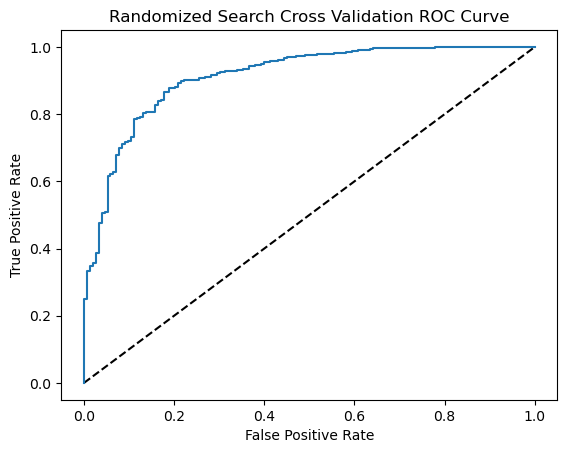

0.9118826420750683


In [86]:
sentiment_prob = rs.predict_proba(X_test['spacy_text'])
positive_class_prob = sentiment_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, positive_class_prob, pos_label = 1)
plt.plot([0, 1], [0, 1],
'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Randomized Search Cross Validation ROC Curve')
plt.show()

print(roc_auc_score(y_test, positive_class_prob))

In [90]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range = (1,2))

X_train_tf = tfidf.fit_transform(X_train['spacy_text'])
X_test_tf = tfidf.transform(X_test['spacy_text'])

linear = LinearSVC(random_state = 42, tol = 1e-5)
linear.fit(X_train_tf, y_train)

LinearSVC(random_state=42, tol=1e-05)

In [92]:
y_pred = linear.predict(X_test_tf)
print ('Accuracy Score:', accuracy_score(Y_test, y_pred))
print ('ROC-AUC Score:', roc_auc_score(Y_test, y_pred))

Accuracy Score -  0.9465526456440406
ROC-AUC Score -  0.7267874941983001


In [95]:
sample_reviews = cleaned_text.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['spacy_text'])
sentiment_predictions = linear.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['text', 'rating', 'sentiment_prediction']]


Some sample reviews with their sentiment - 


,text,rating,sentiment_prediction
221,"very nice for my bookcase, easy to read and lo...",5,1
4229,This cake stand Is made of a beautiful wood. I...,5,1
5739,My daughter has used a similar Twin XL mattres...,5,1
4419,"As another reviewer mentioned, this item is of...",1,0
738,"Wow, what a clever idea! I always am making ka...",5,1
